In [1]:
import librosa
import librosa.display
import numpy as np
from os import listdir
from os import mkdir
from os.path import isfile
from os.path import isdir
from multiprocessing import Pool
import sys
import h5py
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
y, sr = librosa.load('./train/audio/_background_noise_/white_noise.wav', sr=16000)
print(y)
print(y.shape)
print('sampling rate: ' + str(sr))
# y = y[0:2205]
label = 0

[-0.05389404 -0.49334717 -0.53335571 ..., -0.23934937  0.36676025
 -0.15600586]
(960000,)
sampling rate: 16000


In [75]:
EPS = np.spacing(1)
N_MFCC = 20
N_MELS = 40
N_FFT = 1024
HOP_LENGTH = int(0.02 * sr)
WIN_LENGTH = int(0.04 * sr)
FMIN = 0
FMAX = sr / 2
CENTER = True

WIDTH = 9

HTK_MFCC = False
HTK_MEL = True
LOG_MEL = True

In [78]:
def get_mel(y, sr):
    window_ = scipy.signal.hamming(WIN_LENGTH, sym=False)
    mel_basis = librosa.filters.mel(
        sr=sr,
        n_fft=N_FFT,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX,
        htk=HTK_MEL
    )
    
    spectrogram_ = np.abs(librosa.stft(
        y + EPS,
        n_fft=N_FFT,
        win_length=WIN_LENGTH,
        hop_length=HOP_LENGTH,
        center=CENTER,
        window=window_
    ))
    
    mel_spectrum = np.dot(mel_basis, spectrogram_)
    if LOG_MEL:
        mel_spectrum = np.log(mel_spectrum + EPS)
        
    librosa.display.specshow(mel_spectrum)
        
    return mel_spectrum.T

(3001, 40)


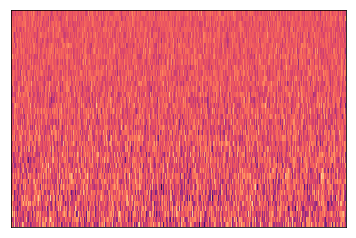

In [79]:
mel = get_mel(y, sr)
print(mel.shape)

In [65]:
def get_mfcc(y, sr):
    window_ = scipy.signal.hamming(WIN_LENGTH, sym=False)
    mel_basis = librosa.filters.mel(
        sr=sr,
        n_fft=N_FFT,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX,
        htk=HTK_MFCC
    )
    
    spectrogram_ = np.abs(librosa.stft(
        y + EPS,
        n_fft=N_FFT,
        win_length=WIN_LENGTH,
        hop_length=HOP_LENGTH,
        center=CENTER,
        window=window_
    ))
    
    mel_spectrum = np.dot(mel_basis, spectrogram_)

    mfcc = librosa.feature.mfcc(S=librosa.logamplitude(mel_spectrum),
                                n_mfcc=N_MFCC)
    
    return mfcc.T

In [66]:
mfcc = get_mfcc(y, sr)
print(mfcc.shape)

(3001, 20)


In [67]:
def get_mfcc_delta(mfcc):
    delta = librosa.feature.delta(mfcc, WIDTH)

    # mfcc is already .T
    return delta

In [68]:
mfcc_del = get_mfcc_delta(mfcc)
print(mfcc_del.shape)

(3001, 20)


In [69]:
def get_mfcc_acceleration(mfcc):
    acceleration = librosa.feature.delta(
        mfcc,
        order=2,
        width=WIDTH
    )

    # mfcc is already .T
    return acceleration

In [70]:
mfcc_acc = get_mfcc_acceleration(mfcc)
print(mfcc_acc.shape)

(3001, 20)


In [71]:
feature_v = np.empty((0, 101))
for i in range(len(mel)):
    feature = np.hstack([mel[i], mfcc[i], mfcc_del[i], mfcc_acc[i], label])
    feature_v = np.vstack((feature_v, feature))
print(feature_v.shape)

(3001, 101)
